In [1]:
with open('../data/Korean_movie_reviews_2016_small.txt', encoding='utf-8') as f:
    docs = [doc.strip().split('\t') for doc in f ]
    docs = [(doc[0], int(doc[1])) for doc in docs if len(doc) == 2]
    texts, labels = zip(*docs)

In [2]:
len(texts)

29875

In [3]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

In [4]:
tokenizer = BertTokenizer.from_pretrained("klue/bert-base")

In [5]:
model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
from tensorflow.keras.utils import to_categorical
y_one_hot = to_categorical(labels)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(texts, y_one_hot, test_size=0.2, random_state=0)

In [8]:
len(X_train)

23900

In [9]:
X_train_tokenized = tokenizer(X_train, return_tensors="np", max_length=30, padding='max_length', truncation=True)
X_test_tokenized = tokenizer(X_test, return_tensors="np", max_length=30, padding='max_length', truncation=True)

In [10]:
optimizer = tf.keras.optimizers.Adam(2e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
checkpoint_filepath = "./checkpoints/checkpoint_bert_klue"
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', 
                     save_best_only=True, save_weights_only=True)

In [12]:
history = model.fit(dict(X_train_tokenized), y_train, epochs=10, batch_size=128, 
                    validation_split=0.1, callbacks=[es, mc])

Epoch 1/10
169/169 [==============================] - 996s 6s/step - loss: 0.3394 - accuracy: 0.8570 - val_loss: 0.2767 - val_accuracy: 0.8879
Epoch 2/10
169/169 [==============================] - 955s 6s/step - loss: 0.2182 - accuracy: 0.9146 - val_loss: 0.2624 - val_accuracy: 0.8975
Epoch 3/10
169/169 [==============================] - 958s 6s/step - loss: 0.1592 - accuracy: 0.9418 - val_loss: 0.2875 - val_accuracy: 0.8874
Epoch 4/10
169/169 [==============================] - 956s 6s/step - loss: 0.1094 - accuracy: 0.9627 - val_loss: 0.2995 - val_accuracy: 0.8954
Epoch 5/10
169/169 [==============================] - 955s 6s/step - loss: 0.0735 - accuracy: 0.9756 - val_loss: 0.4019 - val_accuracy: 0.8858
Epoch 5: early stopping


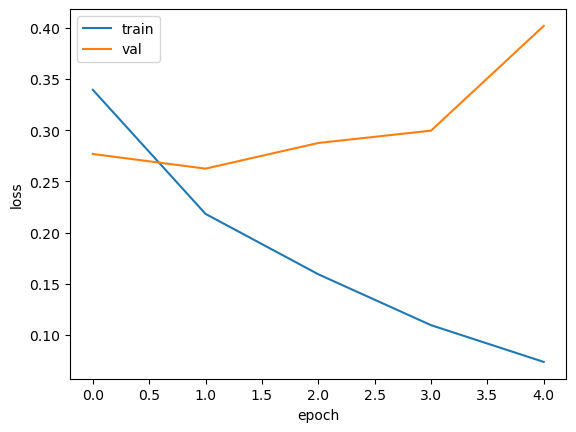

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

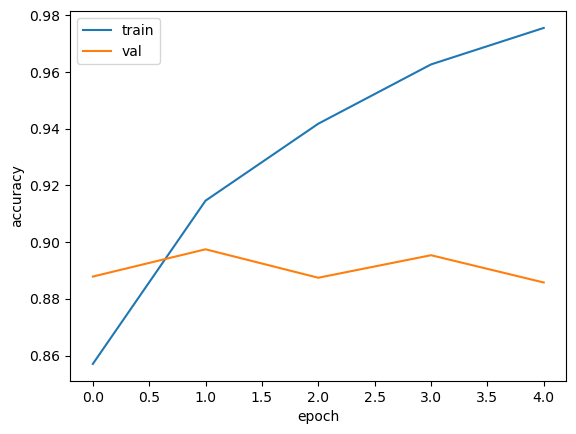

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

In [15]:
model.load_weights(checkpoint_filepath)
model.evaluate(dict(X_test_tokenized), y_test)

187/187 [==============================] - 83s 441ms/step - loss: 0.2482 - accuracy: 0.8986


[0.2481621354818344, 0.8985773921012878]

In [16]:
y_preds = model.predict(dict(X_test_tokenized))

187/187 [==============================] - 85s 444ms/step


In [17]:
prediction_probs = tf.nn.softmax(y_preds.logits,axis=1).numpy()

In [18]:
import numpy as np
y_predictions = np.argmax(prediction_probs, axis=1)

In [19]:
y_test = np.argmax(y_test, axis=1)

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_predictions, y_test))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      2885
           1       0.90      0.91      0.90      3090

    accuracy                           0.90      5975
   macro avg       0.90      0.90      0.90      5975
weighted avg       0.90      0.90      0.90      5975

